In [2]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join, isfile
from matplotlib.image import imread
import matplotlib.pyplot as plt
import tensorflow as tf

2025-07-16 20:28:55.091868: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 20:28:55.095825: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 20:28:55.107006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752708535.125954    4396 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752708535.131513    4396 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 20:28:55.151119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Preprocess data

In [3]:
path = 'images/'
species_label = 'species'
image_label = 'img'      
image_width = 128
image_height = 128
image_size = [image_width, image_height]

In [4]:
labels_existents = dict()
for filename in listdir(path):
    full_path = join(path, filename)
    label = filename[4:].replace("_", " ").split(" ")[-1]
    if (label not in labels_existents):
        labels_existents[label] = 1
    else:
        labels_existents[label] = labels_existents[label] + 1


print({k: v for k, v in sorted(labels_existents.items(), key=lambda item: item[1],reverse=True)})
allowed_birds = ['Wren', "Vireo", "Tern", "Gull"]


{'Warbler': 25, 'Sparrow': 21, 'Gull': 8, 'Wren': 7, 'Flycatcher': 7, 'Tern': 7, 'Vireo': 7, 'Woodpecker': 6, 'Kingfisher': 5, 'Oriole': 4, 'Grebe': 4, 'Swallow': 4, 'Blackbird': 4, 'Grosbeak': 4, 'Auklet': 3, 'Cormorant': 3, 'Bunting': 3, 'Hummingbird': 3, 'Cuckoo': 3, 'Jay': 3, 'Cowbird': 2, 'Waterthrush': 2, 'Crow': 2, 'Catbird': 2, 'Thrasher': 2, 'Tanager': 2, 'Waxwing': 2, 'Shrike': 2, 'Towhee': 2, 'Goldfinch': 2, 'Jaeger': 2, 'Kingbird': 2, 'Finch': 2, 'Raven': 2, 'Pelican': 2, 'Merganser': 2, 'Will': 1, 'Nutcracker': 1, 'Pewee': 1, 'Mallard': 1, 'Nuthatch': 1, 'Guillemot': 1, 'Sayornis': 1, 'Junco': 1, 'Lark': 1, 'Mockingbird': 1, 'Starling': 1, 'Puffin': 1, 'Chat': 1, 'Kittiwake': 1, 'Pipit': 1, 'Meadowlark': 1, 'Frigatebird': 1, 'Creeper': 1, 'Flicker': 1, 'Grackle': 1, 'Loon': 1, 'Redstart': 1, 'Cardinal': 1, 'Nighthawk': 1, 'Bobolink': 1, 'Violetear': 1, 'Ovenbird': 1, 'Gadwall': 1, 'Geococcyx': 1, 'Widow': 1, 'Fulmar': 1, 'Yellowthroat': 1}


In [5]:
data = {species_label: [], image_label: []}
img_shapes = []

for filename in listdir(path):
    full_path = join(path, filename)
    label = filename[4:].replace("_", " ").split(" ")[-1]
    if (label not in allowed_birds):
        continue
    for image in listdir(full_path):
        img_full_path = join(full_path, image)
        
        img_bytes = imread(img_full_path)
        img_constant = tf.constant(img_bytes)
        if (len(img_constant.shape) < 3):
            img_constant = img_constant[..., tf.newaxis]
            img_constant = tf.image.grayscale_to_rgb(img_constant)
            print(img_constant.shape)
        img_constant = tf.image.central_crop(img_constant, 0.8)
        img_resized = tf.image.resize(img_constant, image_size)
        data[species_label].append(label)
        data[image_label].append(img_resized.numpy())


2025-07-16 20:29:02.315723: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(281, 500, 3)
(398, 500, 3)
(326, 500, 3)


# Training Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation,RandomZoom, RandomContrast, Dropout, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [7]:
x = np.array(data[image_label], dtype=np.uint8)
y = np.array(data[species_label])

x.shape, y.shape


((1715, 128, 128, 3), (1715,))

(<matplotlib.image.AxesImage at 0x7f39b006ed10>,
 <matplotlib.image.AxesImage at 0x7f39b0123490>)

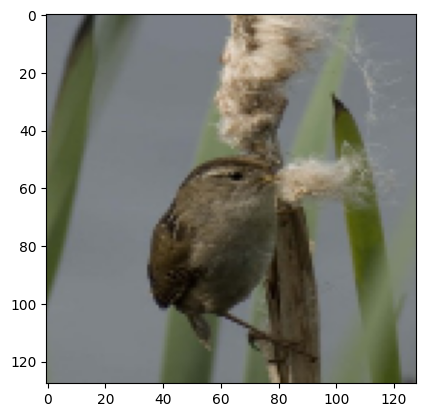

In [8]:


plt.imshow(x[0]), plt.imshow(x[1]), plt.imshow(x[2])

In [9]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded

array([3, 3, 3, ..., 0, 0, 0])

separamos o dataset em teste e validacao, na proporcao 60% treinamento, 20% validacao e 20% teste

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded,test_size=0.2,random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1372, 128, 128, 3), (343, 128, 128, 3), (1372,), (343,))

In [11]:
np.unique(y, return_counts=True)

(array(['Gull', 'Tern', 'Vireo', 'Wren'], dtype='<U5'),
 array([469, 418, 409, 419]))

In [25]:
import keras_tuner as kt
from tensorflow.keras import optimizers


class CNNHyperModel(kt.HyperModel):

    def __init__(self, num_classes, input_shape):
        self.num_classes = num_classes
        self.input_shape = input_shape


    def build(self, hp):
        base_model = tf.keras.Sequential()
        base_model.add(Input(shape=self.input_shape))
        base_model.add(Rescaling(1./255))

        base_model.add(RandomFlip("horizontal_and_vertical"))
        base_model.add(RandomRotation(0.1))
        base_model.add(RandomTranslation(height_factor=0.1, width_factor=0.1))

        hp_filters_first_conv = hp.Choice('first_conv', values=[16,32])
        hp_filters_second_conv = hp.Choice('second_conv', values=[32,64])
        hp_filters_third_conv = hp.Choice('third_conv', values=[64,128])

        base_model.add(Conv2D(hp_filters_first_conv,(3, 3), activation='relu'))
        base_model.add(MaxPooling2D(2, 2))


        base_model.add(Conv2D(hp_filters_second_conv,(3, 3), activation='relu'))
        base_model.add(MaxPooling2D(2, 2))
        

        base_model.add(Conv2D(hp_filters_third_conv,(3, 3), activation='relu'))
        base_model.add(MaxPooling2D(2, 2))

        base_model.add(Flatten(name='flatten'))
        hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
        base_model.add(Dense(units=hp_units, activation='relu'))
        base_model.add(Dense(self.num_classes, activation='softmax'))
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        
        base_model.compile(optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
        
        return base_model

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
num_classes = len(encoder.classes_)

print(num_classes)

tuner = kt.BayesianOptimization(CNNHyperModel(num_classes, x[0].shape),
                    objective='val_accuracy',
                    directory='hyperparams',
                    project_name='bird_classification')


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


tuner.search(x_train, y_train, epochs=100, validation_split=0.25, callbacks=[stop_early, reduce_lr])

4
Reloading Tuner from hyperparams/bird_classification/tuner0.json


In [30]:
best_hp = tuner.get_best_hyperparameters()[0]

model = tuner.hypermodel.build(best_hp)
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.2911 - loss: 1.4309 - val_accuracy: 0.5044 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step - accuracy: 0.4467 - loss: 1.1494 - val_accuracy: 0.4869 - val_loss: 1.0217 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.4770 - loss: 1.0673 - val_accuracy: 0.4461 - val_loss: 1.0821 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.4873 - loss: 1.0202 - val_accuracy: 0.4461 - val_loss: 1.1430 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 320ms/step - accuracy: 0.5239 - loss: 1.0280 - val_accuracy: 0.4781 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 304ms/step - accuracy: 0.5235 - loss: 1.0077 - val_accuracy: 0.5802 - val_loss: 0.9658 - learning_rate: 0.0010
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step - accuracy: 0.5714 - l

In [40]:
import matplotlib.pyplot as plt

def plot_loss_function(trained_model):
  plt.figure(figsize=(10, 6))
  plt.plot(trained_model.history['loss'], label='Training Loss')
  plt.plot(trained_model.history['val_loss'], label='Validation Loss')
  plt.title('Cost Function over Epochs ')
  plt.xlabel('Epochs')
  plt.ylabel('Cost')
  plt.legend()
  plt.grid(True)
  plt.show()


def plot_accuracy_function(trained_model):
  plt.figure(figsize=(10, 6))
  plt.plot(trained_model.history['accuracy'], label='Training accuracy')
  plt.plot(trained_model.history['val_accuracy'], label='Validation accuracy')
  plt.title('Accuracy over Epochs ')
  plt.xlabel('Epochs')
  plt.ylabel('Cost')
  plt.legend()
  plt.grid(True)
  plt.show()

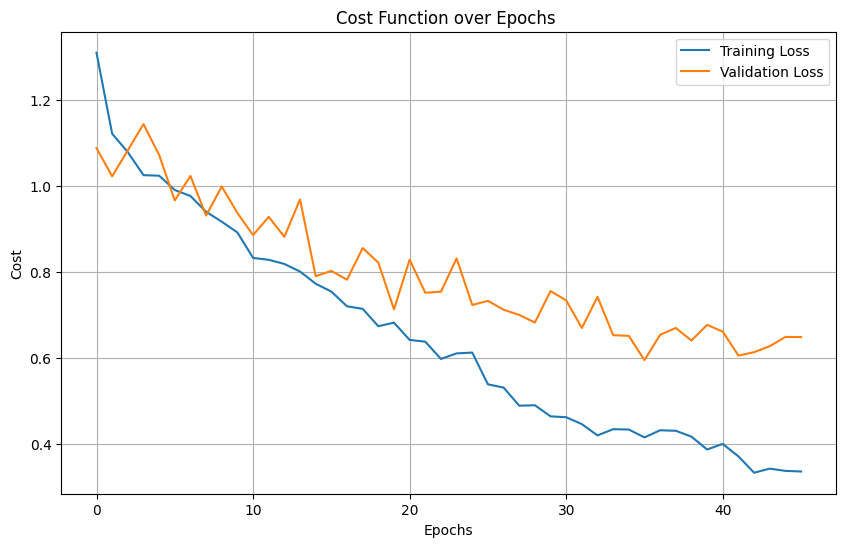

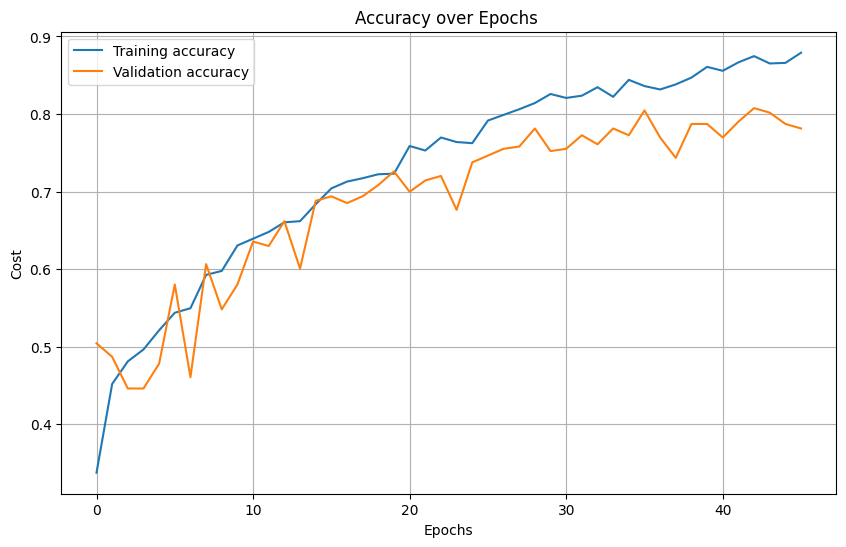

(None, None)

In [41]:
plot_loss_function(history), plot_accuracy_function(history)

predicao

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
def print_confusion_matrix(y_test, predictions):
    cm = tf.math.confusion_matrix(y_test, predictions)
    ConfusionMatrixDisplay(cm.numpy(), display_labels=encoder.classes_).plot()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


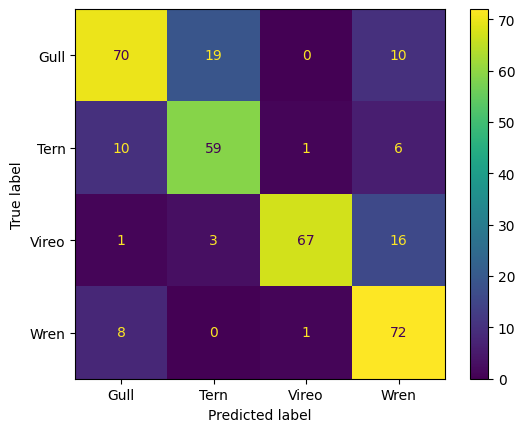

In [43]:
model_pred = model.predict(x_test).argmax(1)
print_confusion_matrix(y_test, model_pred)


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model_pred))


              precision    recall  f1-score   support

           0       0.79      0.71      0.74        99
           1       0.73      0.78      0.75        76
           2       0.97      0.77      0.86        87
           3       0.69      0.89      0.78        81

    accuracy                           0.78       343
   macro avg       0.79      0.79      0.78       343
weighted avg       0.80      0.78      0.78       343



# Random Forest

In [45]:
from tensorflow.keras.models import Model 
feature_extractor = Model(
    inputs=model.inputs,
    outputs=model.get_layer(name='flatten').output
)


In [37]:

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
x_with_cnn_train = feature_extractor.predict(x_train)
x_with_cnn_test = feature_extractor.predict(x_test)

rf_model.fit(x_with_cnn_train, y_train)
rf_model.score(x_with_cnn_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


0.6880466472303207

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(x_with_cnn_train, y_train)


best_rf_model = grid_search.best_estimator_
accuracy = best_rf_model.score(x_with_cnn_test, y_test)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.1s
[CV] END max_depth=10, min_s

              precision    recall  f1-score   support

           0       0.68      0.70      0.69        99
           1       0.65      0.51      0.57        76
           2       0.77      0.80      0.79        87
           3       0.68      0.75      0.71        81

    accuracy                           0.70       343
   macro avg       0.69      0.69      0.69       343
weighted avg       0.69      0.70      0.69       343



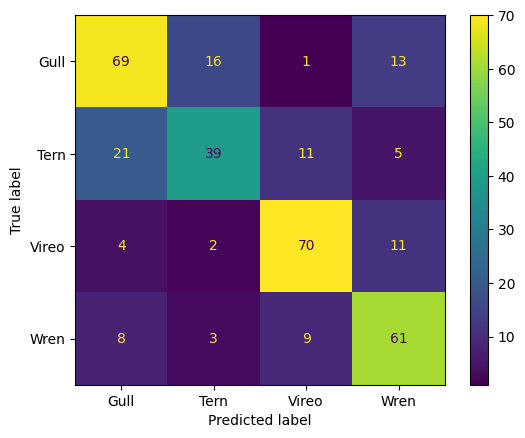

In [47]:

y_pred = best_rf_model.predict(x_with_cnn_test)

print(classification_report(y_test, y_pred))

print_confusion_matrix(y_test, y_pred)